The paper we are replicating here is : [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/pdf/1710.06071)

The model in this paper comes from : [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251)

<img src="model.png" width="20%" style="display: block; margin-left: auto; margin-right: auto;">


In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
%ls pubmed-rct

 Volume in drive D is Data
 Volume Serial Number is 4827-F442

 Directory of D:\Udemy - Courses\TensorFlow-Udemy\pubmed-rct

13-10-2024  17:53    <DIR>          .
19-10-2024  22:41    <DIR>          ..
13-10-2024  19:10    <DIR>          PubMed_200k_RCT
13-10-2024  19:10    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
13-10-2024  17:53    <DIR>          PubMed_20k_RCT
13-10-2024  17:53    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
13-10-2024  17:53             3,733 README.md
               1 File(s)          3,733 bytes
               6 Dir(s)  18,741,084,160 bytes free


In [2]:
# Check what files are in the PubMed_20K dataset 
%ls "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"
%ls "pubmed-rct/PubMed_20k_RCT"

 Volume in drive D is Data
 Volume Serial Number is 4827-F442

 Directory of D:\Udemy - Courses\TensorFlow-Udemy\pubmed-rct\PubMed_20k_RCT_numbers_replaced_with_at_sign

13-10-2024  17:53    <DIR>          .
13-10-2024  17:53    <DIR>          ..
13-10-2024  17:53         4,880,409 dev.txt
13-10-2024  17:53         4,846,504 test.txt
13-10-2024  17:53        29,118,832 train.txt
               3 File(s)     38,845,745 bytes
               2 Dir(s)  18,741,084,160 bytes free
 Volume in drive D is Data
 Volume Serial Number is 4827-F442

 Directory of D:\Udemy - Courses\TensorFlow-Udemy\pubmed-rct\PubMed_20k_RCT

13-10-2024  17:53    <DIR>          .
13-10-2024  17:53    <DIR>          ..
13-10-2024  17:53         4,962,110 dev.txt
13-10-2024  17:53         4,924,980 test.txt
13-10-2024  17:53        29,594,141 train.txt
               3 File(s)     39,481,231 bytes
               2 Dir(s)  18,741,084,160 bytes free


In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys, calculate_results

In [4]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

### Preprocess the data

In [6]:
def get_lines(filename):
    with open(filename, 'r') as f:
        return f.readlines()

In [7]:
train_lines = get_lines(data_dir + "test.txt")
train_lines[:10]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [8]:
def preprocess_text_with_line_numbers(filename):
     input_lines = get_lines(filename)
     abstract_lines = ""
     abstract_samples = []
     
     for line in input_lines:
         if line.startswith("###"):
             abstract_id = line
             abstract_lines = ""
         elif line.isspace():
             abstract_line_split = abstract_lines.splitlines()
             for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                 line_data = {}
                 target_text_split = abstract_line.split("\t")
                 line_data["target"] = target_text_split[0]
                 line_data["text"] = target_text_split[1].lower()
                 line_data["line_number"] = abstract_line_number
                 line_data["total_lines"] = len(abstract_line_split) - 1
                 abstract_samples.append(line_data)
       
         else:
             abstract_lines += line
     
     return abstract_samples

In [9]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: total: 594 ms
Wall time: 765 ms


(180040, 30212, 30135)

In [10]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [12]:
train_df.head(13)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

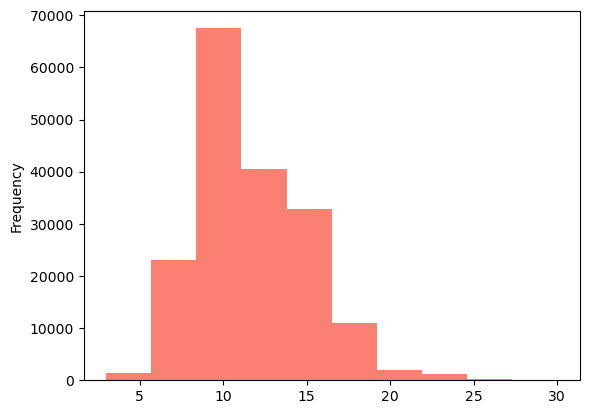

In [14]:
train_df.total_lines.plot.hist(color='salmon')

<Axes: ylabel='target'>

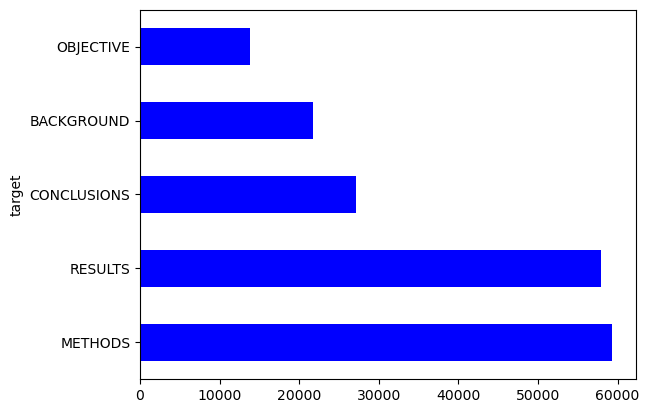

In [15]:
train_df['target'].value_counts().plot.barh(color='blue')

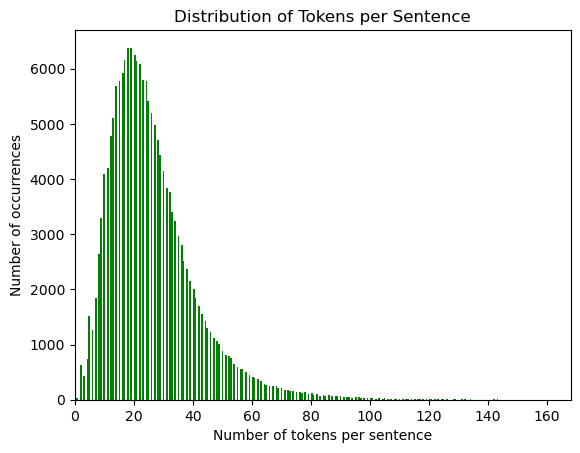

In [16]:
import matplotlib.pyplot as plt
num_tokens = train_df['text'].apply(lambda x: len(x.split()))

plt.hist(num_tokens, bins=280, color='green', range=(0, 160))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Number of tokens per sentence')
plt.ylabel('Number of occurrences')
plt.title('Distribution of Tokens per Sentence')
plt.show()

In [17]:
# Convert abstract text lines into lists 
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [19]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))

In [20]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

In [23]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model 0 : Naive Bayes (baseline)

In [25]:
# build and fit the model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [26]:
# evaluate the model
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [27]:
# make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [28]:
# calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing the data for deep sequence models


In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

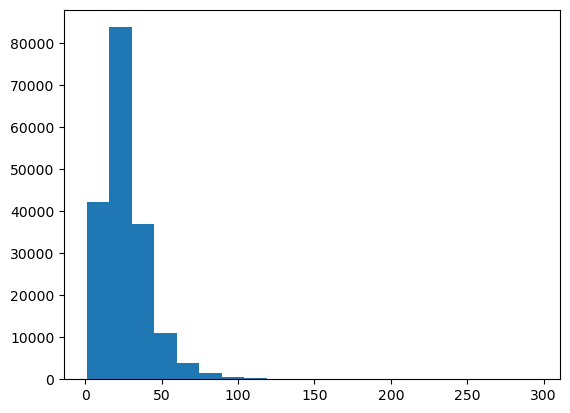

In [31]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [32]:
import numpy as np
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [33]:
max(sent_lens)

296

### Text vectorizer layer

In [34]:
max_token = 68000

In [35]:
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_token,
                                    output_sequence_length=output_seq_len)

In [36]:
text_vectorizer.adapt(train_sentences)

In [37]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
subjective cure rates were @ % for tvt-o and @ % for tvt-s .

Length of text: 14

Vectorized text:
[[  822  2002   162     9    11  7133     3    11 21470     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [38]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

### Custom text embedding

In [40]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding") 

print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
subjective cure rates were @ % for tvt-o and @ % for tvt-s .

Sentence after vectorization (before embedding):
[[  822  2002   162     9    11  7133     3    11 21470     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.02354487 -0.04209686 -0.02476528 ...  0.02589471 -0.03943295
   -0.0469065 ]
  [-0.01852704  0.04157057 -0.04928918 ...  0.01041891 -0.0355785
    0.0209755 ]
  [-0.02612691  0.02990225  0.02029428 ...  0.03552089 -0.01366937
    0.0143876 ]
  ...
  [-0.00728829 -0.00788326  0.02143762 ...  0.03890964 -0.00285091
   -0.00482016]
  [-0.00728829 -0.00788326  0.02143762 ...  0.03890964 -0.00285091
   -0.00482016]
  [-0.00728829 -0.00788326  0.02143762 ...  0.03890964 -0.00285091
  

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [43]:
# build the model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

In [44]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [45]:
# compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=tf.keras.metrics.Accuracy())

In [46]:
# fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=10,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 44s 75ms/step - loss: 0.9342 - accuracy: 0.0000e+00 - val_loss: 0.6929 - val_accuracy: 0.0000e+00
Epoch 2/10
562/562 [==============================] - 47s 83ms/step - loss: 0.6616 - accuracy: 0.0000e+00 - val_loss: 0.6277 - val_accuracy: 0.0000e+00
Epoch 3/10
562/562 [==============================] - 47s 84ms/step - loss: 0.6172 - accuracy: 0.0000e+00 - val_loss: 0.5948 - val_accuracy: 0.0000e+00
Epoch 4/10
562/562 [==============================] - 40s 71ms/step - loss: 0.5575 - accuracy: 0.0000e+00 - val_loss: 0.5422 - val_accuracy: 0.0000e+00
Epoch 8/10
562/562 [==============================] - 41s 73ms/step - loss: 0.5391 - accuracy: 0.0000e+00 - val_loss: 0.5287 - val_accuracy: 0.0000e+00
Epoch 9/10
562/562 [==============================] - 40s 71ms/step - loss: 0.5421 - accuracy: 0.0000e+00 - val_loss: 0.5296 - val_accuracy: 0.0000e+00


In [47]:
model_1.evaluate(test_dataset)

942/942 [==============================] - 4s 4ms/step - loss: 0.5392 - accuracy: 0.0000e+00


[0.5392060875892639, 0.0]

In [48]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 4s 4ms/step


(array([[5.3299814e-01, 1.0235241e-01, 1.1222403e-01, 2.0620191e-01,
         4.6223540e-02],
        [5.2173704e-01, 2.0251390e-01, 9.6829692e-03, 2.4507438e-01,
         2.0991711e-02],
        [1.4878544e-01, 5.1529137e-03, 7.0302829e-04, 8.4530067e-01,
         5.7880923e-05],
        ...,
        [1.1706679e-05, 2.5216554e-04, 2.4564252e-03, 7.9050233e-06,
         9.9727184e-01],
        [1.2071994e-01, 4.5782179e-01, 1.6178139e-01, 9.0063915e-02,
         1.6961299e-01],
        [3.2873198e-02, 9.4356245e-01, 1.9314358e-02, 1.2262879e-03,
         3.0237406e-03]], dtype=float32),
 (30212, 5))

In [49]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [50]:
model_1_results = calculate_results(y_true=val_labels_encoded, y_pred=model_1_preds)
model_1_results

{'accuracy': 81.25248245730174,
 'precision': 0.8084025675122871,
 'recall': 0.8125248245730173,
 'f1': 0.8091514835661306}

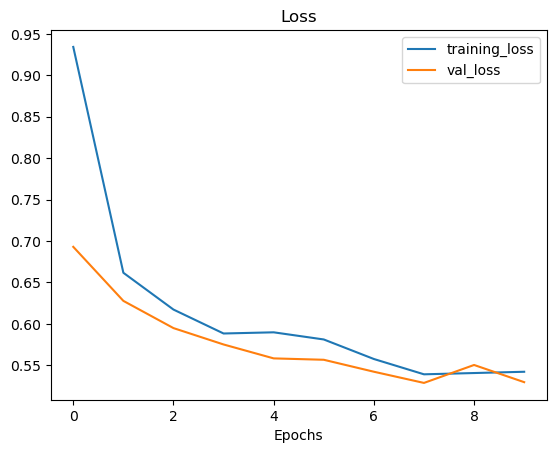

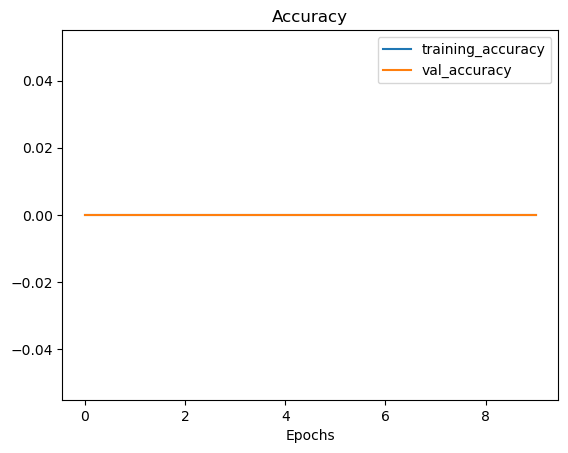

In [51]:
plot_loss_curves(model_1_history)

## Model 2: Feature extraction with pretrained token embeddings

In [52]:
import tensorflow_hub as hub

In [53]:
tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [54]:
# test the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
against this background , the following objectives are pursued : ( @ ) to estimate the relative odds and prevalence rates of self-reported disorders of the upper limbs and/or shoulders and neck ( upper body ) and the lower limbs for major isco-@ occupational groups , ( @ ) to evaluate to what extent the associations between known risk factors differ for musculoskeletal disorders of the upper body and the lower limbs .

Sentence after embedding:
[ 0.00438525  0.06321865 -0.02189302 -0.04697602  0.00648601 -0.00361864
  0.02157853 -0.00305482 -0.05998199  0.01754165  0.07397415 -0.02216144
 -0.06087613 -0.06359106  0.06120688 -0.04291818 -0.07401317 -0.03394761
  0.05157964 -0.01800393  0.06087204  0.0571992  -0.07059387  0.00575859
  0.06336854  0.03403696 -0.06012116 -0.00739046  0.01462653 -0.04050139] (truncated output)...

Length of sentence embedding:
512


In [55]:
# build the model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_2')

In [56]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,880,645
Trainable params: 82,821
Non-trainable params: 256,797,824
________________________________________

In [57]:
# compile the mode
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=tf.keras.metrics.Accuracy())

In [58]:
# fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=10,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 8s 9ms/step - loss: 0.8789 - accuracy: 0.0000e+00 - val_loss: 0.7660 - val_accuracy: 0.0000e+00
Epoch 2/10
562/562 [==============================] - 6s 11ms/step - loss: 0.7299 - accuracy: 0.0000e+00 - val_loss: 0.7070 - val_accuracy: 0.0000e+00
Epoch 3/10
562/562 [==============================] - 7s 12ms/step - loss: 0.7045 - accuracy: 0.0000e+00 - val_loss: 0.6798 - val_accuracy: 0.0000e+00
Epoch 4/10
562/562 [==============================] - 6s 12ms/step - loss: 0.6765 - accuracy: 0.0000e+00 - val_loss: 0.6611 - val_accuracy: 0.0000e+00
Epoch 5/10
562/562 [==============================] - 6s 11ms/step - loss: 0.6828 - accuracy: 0.0000e+00 - val_loss: 0.6491 - val_accuracy: 0.0000e+00
Epoch 6/10
562/562 [==============================] - 6s 11ms/step - loss: 0.6791 - accuracy: 0.0000e+00 - val_loss: 0.6427 - val_accuracy: 0.0000e+00
Epoch 7/10
562/562 [==============================] - 6s 11ms/step - loss: 0.6500 - accuracy: 0

In [59]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.6229 - accuracy: 0.0000e+00


[0.6228504180908203, 0.0]

In [60]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 10ms/step


array([[4.2176285e-01, 4.3347958e-01, 5.9011066e-04, 1.4068165e-01,
        3.4858843e-03],
       [3.8850054e-01, 5.1831758e-01, 1.8986771e-03, 8.9493640e-02,
        1.7894527e-03],
       [5.0677031e-01, 1.9984452e-02, 2.3942757e-02, 4.4010726e-01,
        9.1952719e-03],
       ...,
       [6.6419051e-04, 9.4240619e-04, 1.0667233e-02, 1.8331622e-04,
        9.8754287e-01],
       [1.0995890e-02, 6.8691798e-02, 6.5679222e-02, 2.2923599e-03,
        8.5234076e-01],
       [7.8156382e-02, 9.1734588e-01, 3.5157227e-03, 2.2959895e-04,
        7.5236231e-04]], dtype=float32)

In [61]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 1], dtype=int64)>

In [62]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 76.32397722759168,
 'precision': 0.7588239118211321,
 'recall': 0.7632397722759169,
 'f1': 0.7589794965684593}

In [63]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

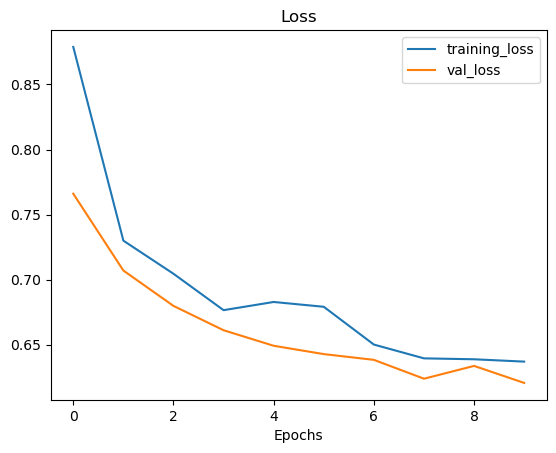

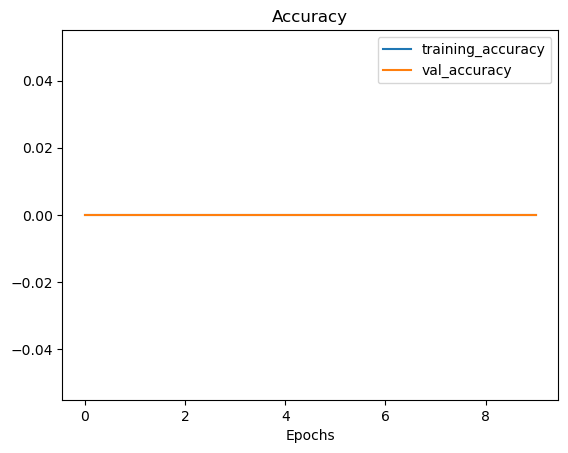

In [64]:
plot_loss_curves(model_2_history)

## Model 3: Conv1D with character embeddings

In [65]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [66]:
def split_chars(text):
    return " ".join(list(text))

In [67]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [68]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

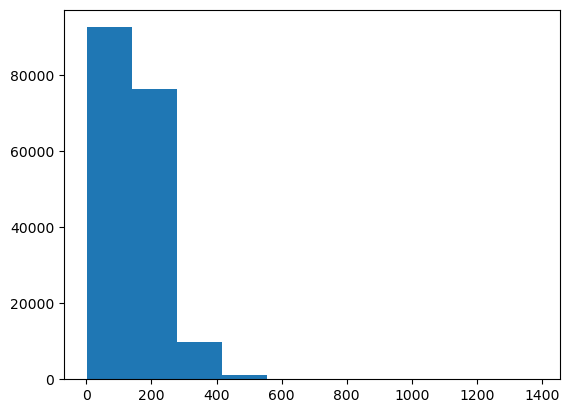

In [69]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=10)

In [70]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [71]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [73]:
char_vectorizer.adapt(train_chars)

In [74]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [75]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
s o m e   e f f e c t s   d i m i n i s h e d   d u r i n g   t h e   @ - w e e k   f o l l o w - u p   p e r i o d   .

Length of chars: 52

Vectorized chars:
[[ 9  7 15  2  2 17 17  2 11  3  9 10  4 15  4  6  4  9 13  2 10 10 16  8
   4  6 18  3 13  2 20  2  2 23 17  7 12 12  7 20 16 14 14  2  8  4  7 10
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0

In [76]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
s o m e   e f f e c t s   d i m i n i s h e d   d u r i n g   t h e   @ - w e e k   f o l l o w - u p   p e r i o d   .

Embedded chars (after vectorization and embedding):
[[[-0.04795092  0.00963278  0.04561067 ...  0.0068982   0.04697584
    0.02417554]
  [ 0.02121079 -0.01039424 -0.01728304 ...  0.02335998 -0.02885306
    0.00490187]
  [-0.04046826  0.03149417 -0.00543014 ... -0.00333302  0.01324889
   -0.02809923]
  ...
  [-0.00399645  0.03524118 -0.00303499 ... -0.03480053  0.02524653
    0.00386836]
  [-0.00399645  0.03524118 -0.00303499 ... -0.03480053  0.02524653
    0.00386836]
  [-0.00399645  0.03524118 -0.00303499 ... -0.03480053  0.02524653
    0.00386836]]]

Character embedding shape: (1, 290, 25)


In [77]:
# build the model
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3")

In [78]:
# compile the model
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=tf.keras.metrics.Accuracy())

In [79]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 5)                 325 

In [80]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [81]:
# fit the model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=10,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/10
562/562 [==============================] - 20s 35ms/step - loss: 1.2540 - accuracy: 0.0000e+00 - val_loss: 1.0429 - val_accuracy: 0.0000e+00
Epoch 2/10
562/562 [==============================] - 8s 15ms/step - loss: 1.0099 - accuracy: 0.0000e+00 - val_loss: 0.9382 - val_accuracy: 0.0000e+00
Epoch 3/10
562/562 [==============================] - 8s 14ms/step - loss: 0.9265 - accuracy: 0.0000e+00 - val_loss: 0.8625 - val_accuracy: 0.0000e+00
Epoch 4/10
562/562 [==============================] - 13s 23ms/step - loss: 0.8777 - accuracy: 0.0000e+00 - val_loss: 0.8358 - val_accuracy: 0.0000e+00
Epoch 5/10
562/562 [==============================] - 11s 19ms/step - loss: 0.8558 - accuracy: 0.0000e+00 - val_loss: 0.8143 - val_accuracy: 0.0000e+00
Epoch 6/10
562/562 [==============================] - 14s 26ms/step - loss: 0.8399 - accuracy: 0.0000e+00 - val_loss: 0.7881 - val_accuracy: 0.0000e+00
Epoch 7/10
562/562 [==============================] - 12s 21ms/step - loss: 0.8266 - accur

In [82]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.7587 - accuracy: 0.0000e+00


[0.7587490081787109, 0.0]

In [83]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[3.7743399e-01, 2.7072537e-01, 3.4278750e-02, 3.0100194e-01,
        1.6559804e-02],
       [7.3620752e-02, 7.6051849e-01, 5.0186750e-04, 1.6226722e-01,
        3.0915977e-03],
       [1.4868268e-01, 3.0032781e-01, 2.4882521e-02, 5.1192343e-01,
        1.4183581e-02],
       ...,
       [8.2417792e-03, 2.4007522e-02, 1.7472137e-02, 1.7379547e-02,
        9.3289900e-01],
       [2.0798484e-02, 1.9376983e-01, 6.3463694e-01, 1.8176883e-02,
        1.3261789e-01],
       [1.2716796e-01, 7.9985082e-01, 2.6365668e-02, 3.7225429e-02,
        9.3900859e-03]], dtype=float32)

In [84]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 2, 1], dtype=int64)>

In [85]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 70.89567059446577,
 'precision': 0.7048162636246298,
 'recall': 0.7089567059446578,
 'f1': 0.7044695708101933}

In [86]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

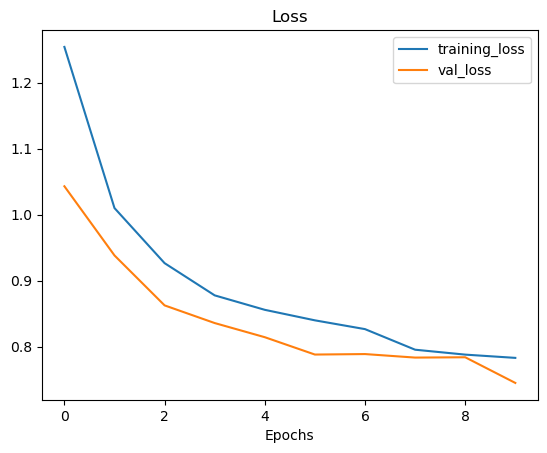

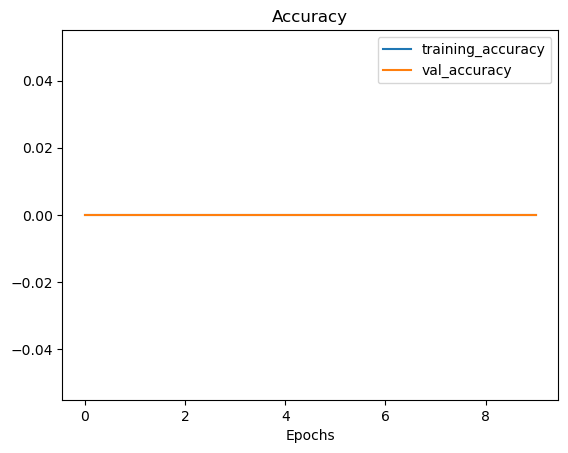

In [87]:
plot_loss_curves(model_3_history)

## Model 4: Combining pretrained token embeddings + character embeddings

In [88]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

In [89]:
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [90]:
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

In [91]:
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [92]:
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4")

In [93]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']      

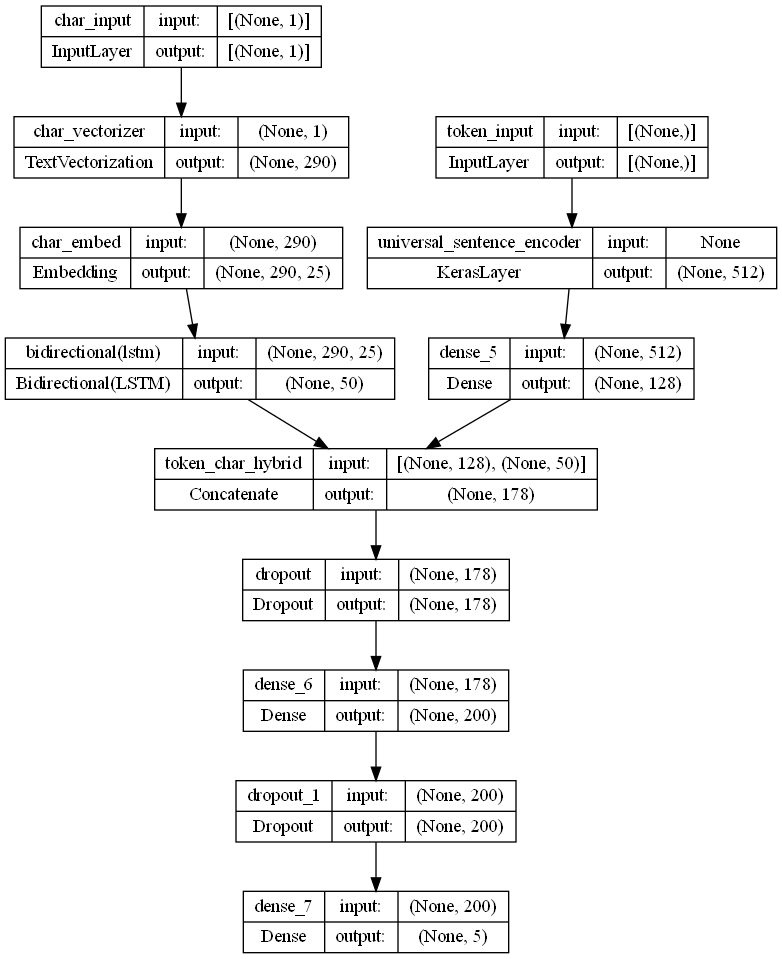

In [94]:
# plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [95]:
# compile the model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=tf.keras.metrics.Accuracy())

In [96]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [97]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [98]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [99]:
# fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=10,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/10
562/562 [==============================] - 128s 217ms/step - loss: 0.9669 - accuracy: 0.0000e+00 - val_loss: 0.7779 - val_accuracy: 0.0000e+00
Epoch 2/10
562/562 [==============================] - 124s 220ms/step - loss: 0.7948 - accuracy: 0.0000e+00 - val_loss: 0.7171 - val_accuracy: 0.0000e+00
Epoch 3/10
562/562 [==============================] - 99s 175ms/step - loss: 0.7662 - accuracy: 0.0000e+00 - val_loss: 0.6889 - val_accuracy: 0.0000e+00
Epoch 4/10
562/562 [==============================] - 99s 176ms/step - loss: 0.7335 - accuracy: 0.0000e+00 - val_loss: 0.6642 - val_accuracy: 0.0000e+00
Epoch 5/10
562/562 [==============================] - 98s 174ms/step - loss: 0.7459 - accuracy: 0.0000e+00 - val_loss: 0.6504 - val_accuracy: 0.0000e+00
Epoch 6/10
562/562 [==============================] - 97s 173ms/step - loss: 0.7370 - accuracy: 0.0000e+00 - val_loss: 0.6496 - val_accuracy: 0.0000e+00
Epoch 7/10
562/562 [==============================] - 97s 172ms/step - loss: 0.7

In [100]:
model_4.evaluate(val_char_token_dataset) 

945/945 [==============================] - 37s 39ms/step - loss: 0.6207 - accuracy: 0.0000e+00


[0.6207291483879089, 0.0]

In [101]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 43s 41ms/step


array([[4.8368451e-01, 3.4943515e-01, 1.9373968e-03, 1.5477523e-01,
        1.0167657e-02],
       [4.3628564e-01, 4.1031459e-01, 5.0997473e-03, 1.4581354e-01,
        2.4863903e-03],
       [5.0845063e-01, 1.0439035e-02, 1.6122615e-02, 4.6203148e-01,
        2.9561750e-03],
       ...,
       [6.7839792e-05, 1.2020259e-03, 4.1172099e-03, 1.1045558e-05,
        9.9460196e-01],
       [1.3105821e-02, 7.2693937e-02, 1.5317909e-01, 4.7570681e-03,
        7.5626403e-01],
       [1.0771922e-01, 8.4293097e-01, 4.3486204e-02, 1.9890561e-03,
        3.8745564e-03]], dtype=float32)

In [102]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 4, 1], dtype=int64)>

In [103]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.33059711372965,
 'precision': 0.7618054647986723,
 'recall': 0.7633059711372965,
 'f1': 0.7593786850256504}

In [104]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

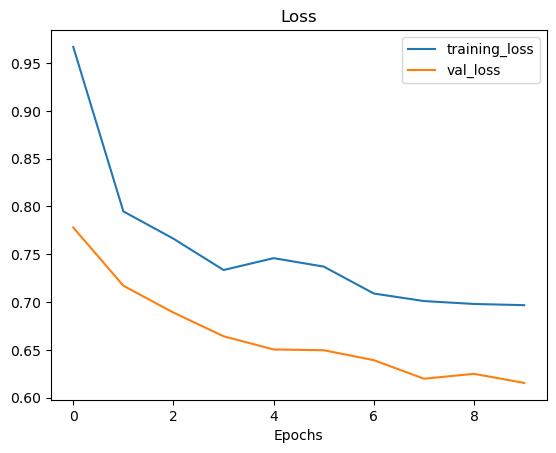

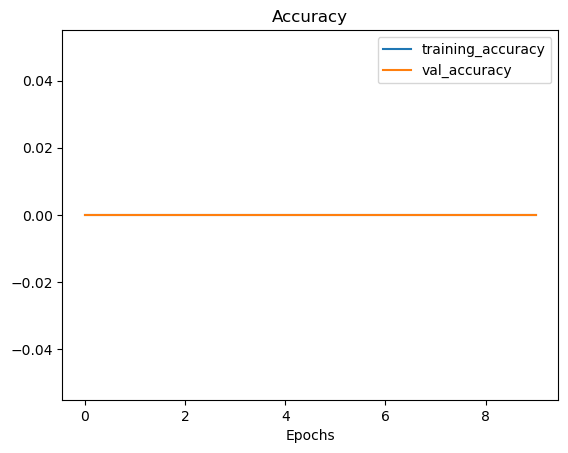

In [105]:
plot_loss_curves(model_4_history)

In [106]:
train_chars[:1]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .']

In [107]:
model_1_results

{'accuracy': 81.25248245730174,
 'precision': 0.8084025675122871,
 'recall': 0.8125248245730173,
 'f1': 0.8091514835661306}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [108]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [109]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

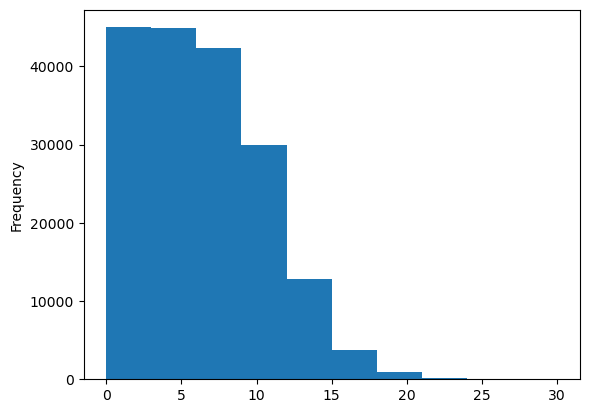

In [110]:
train_df.line_number.plot.hist()

### Create positional embedding

In [137]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [138]:
train_line_number_one_hot[:13], train_line_number_one_hot.shape

(<tf.Tensor: shape=(13, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([

<Axes: ylabel='Frequency'>

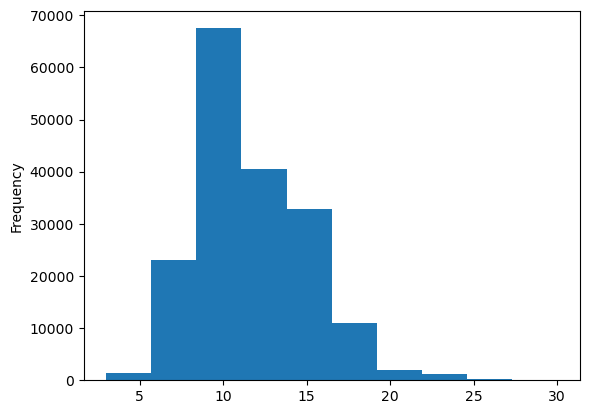

In [139]:
train_df.total_lines.plot.hist()

In [140]:
np.percentile(train_df.total_lines, 98)

20.0

In [141]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a TriBrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a "line_number" model
4. Create a "total_lines" model
5. Combine the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output
6. Combine the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [142]:
# token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# character inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# combine token and char embeddings
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# combine positional embeddings with combined token and char embeddings
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [143]:
model_5.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

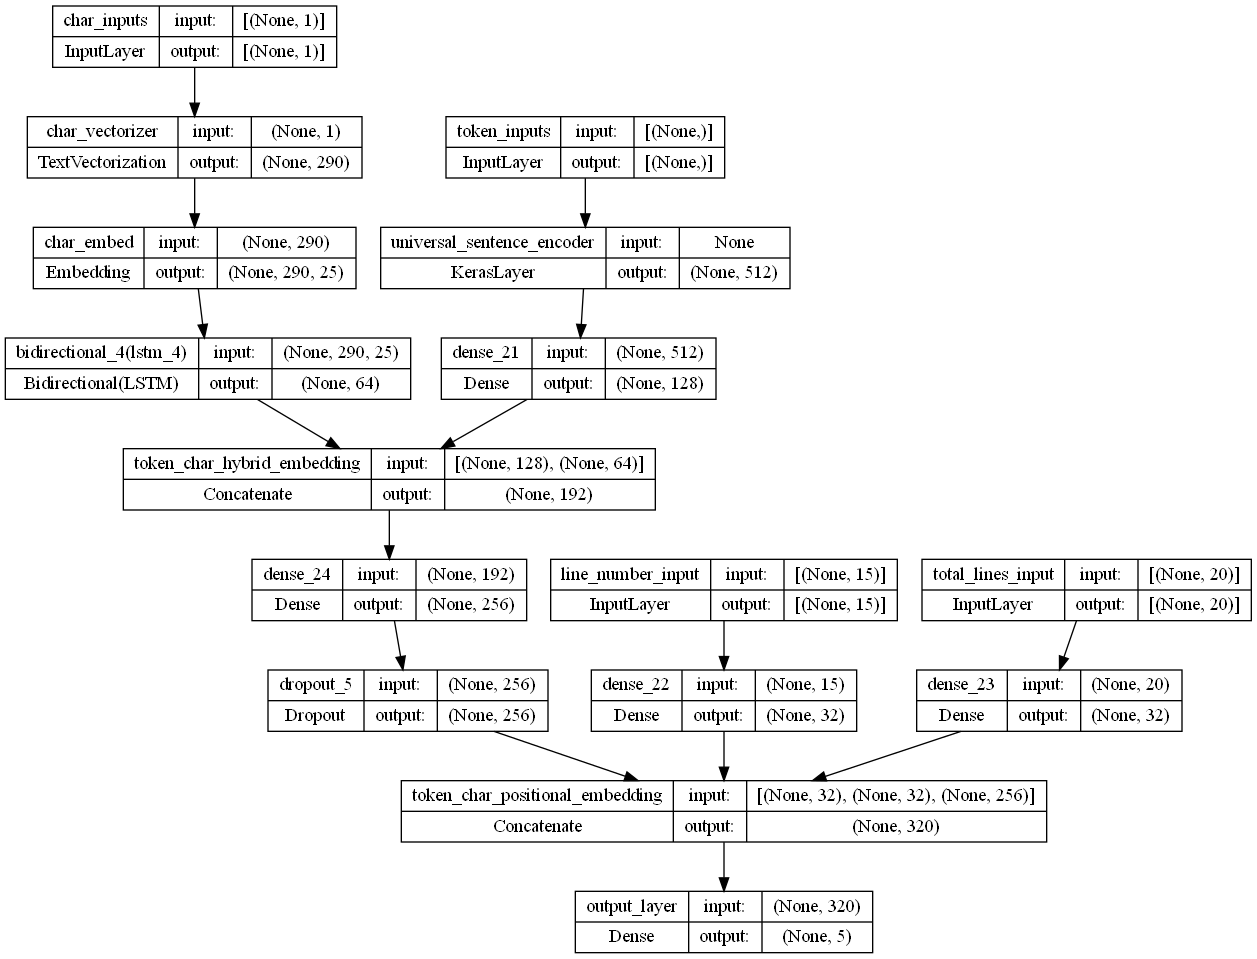

In [144]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [145]:
for layer in model_5.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001BD6D059840> True
<keras.engine.input_layer.InputLayer object at 0x000001BD6D4F22F0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x000001BD4A01E560> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x000001BC8C8994E0> False
<keras.layers.core.embedding.Embedding object at 0x000001BD535E8700> True
<keras.layers.core.dense.Dense object at 0x000001BD6D3CFAF0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x000001BD6E6430D0> True
<keras.layers.merging.concatenate.Concatenate object at 0x000001BD6CFD44C0> True
<keras.engine.input_layer.InputLayer object at 0x000001BD6D5FE0E0> True
<keras.engine.input_layer.InputLayer object at 0x000001BD6D3AC9D0> True
<keras.layers.core.dense.Dense object at 0x000001BD6D058910> True
<keras.layers.core.dense.Dense object at 0x000001BD6D14A4A0> True
<keras.layers.core.dense.Dense object at 0x000001BD6D3F1A20> True
<keras.layers.regularization.dropout.

In [146]:
# compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=tf.keras.metrics.Accuracy())

### Create tribrid embedding datasets

In [148]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [151]:
# fit the model
model_5_history = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/10
562/562 [==============================] - 127s 227ms/step - loss: 1.0551 - accuracy: 0.0000e+00 - val_loss: 0.9805 - val_accuracy: 0.0000e+00
Epoch 2/10
562/562 [==============================] - 131s 233ms/step - loss: 0.9656 - accuracy: 0.0000e+00 - val_loss: 0.9486 - val_accuracy: 0.0000e+00
Epoch 3/10
562/562 [==============================] - 126s 225ms/step - loss: 0.9502 - accuracy: 0.0000e+00 - val_loss: 0.9386 - val_accuracy: 0.0000e+00
Epoch 4/10
562/562 [==============================] - 120s 214ms/step - loss: 0.9388 - accuracy: 0.0000e+00 - val_loss: 0.9296 - val_accuracy: 0.0000e+00
Epoch 5/10
562/562 [==============================] - 116s 207ms/step - loss: 0.9368 - accuracy: 0.0000e+00 - val_loss: 0.9216 - val_accuracy: 0.0000e+00
Epoch 6/10
562/562 [==============================] - 121s 215ms/step - loss: 0.9400 - accuracy: 0.0000e+00 - val_loss: 0.9193 - val_accuracy: 0.0000e+00
Epoch 7/10
562/562 [==============================] - 121s 214ms/step - loss

In [152]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 43s 43ms/step


array([[0.5495883 , 0.09040495, 0.01831566, 0.31442073, 0.02727023],
       [0.5682702 , 0.10707866, 0.06497999, 0.24492219, 0.01474895],
       [0.37956476, 0.08371987, 0.05390433, 0.42849463, 0.0543164 ],
       ...,
       [0.02691367, 0.07767572, 0.02548314, 0.02934192, 0.8405856 ],
       [0.02476695, 0.26702803, 0.04608078, 0.02581732, 0.6363069 ],
       [0.06185879, 0.8318499 , 0.05860445, 0.02146269, 0.02622415]],
      dtype=float32)

In [153]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [154]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.07546670197273,
 'precision': 0.8515471424909322,
 'recall': 0.8507546670197272,
 'f1': 0.8482333428221877}

In [157]:
model_1_results

{'accuracy': 81.25248245730174,
 'precision': 0.8084025675122871,
 'recall': 0.8125248245730173,
 'f1': 0.8091514835661306}

### Compare model results

In [164]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.721832,0.718647,0.721832,0.698925
custom_token_embed_conv1d,0.812525,0.808403,0.812525,0.809151
pretrained_token_embed,0.763240,0.758824,0.763240,0.758979
custom_char_embed_conv1d,0.708957,0.704816,0.708957,0.704470
hybrid_char_token_embed,0.763306,0.761805,0.763306,0.759379
tribrid_pos_char_token_embed,0.850755,0.851547,0.850755,0.848233


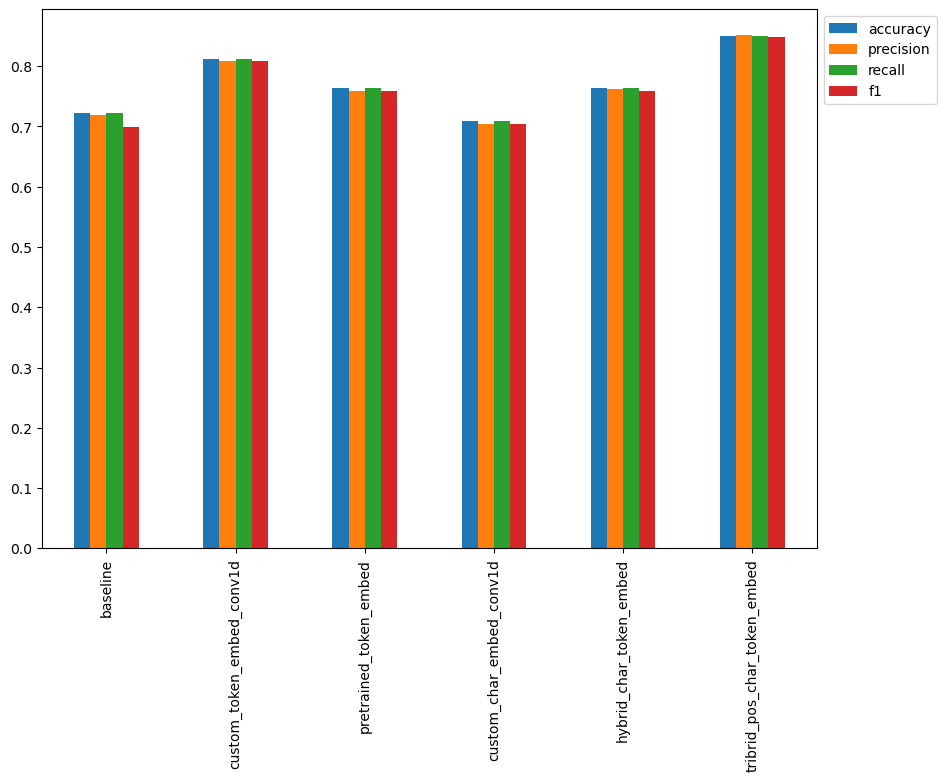

In [167]:
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

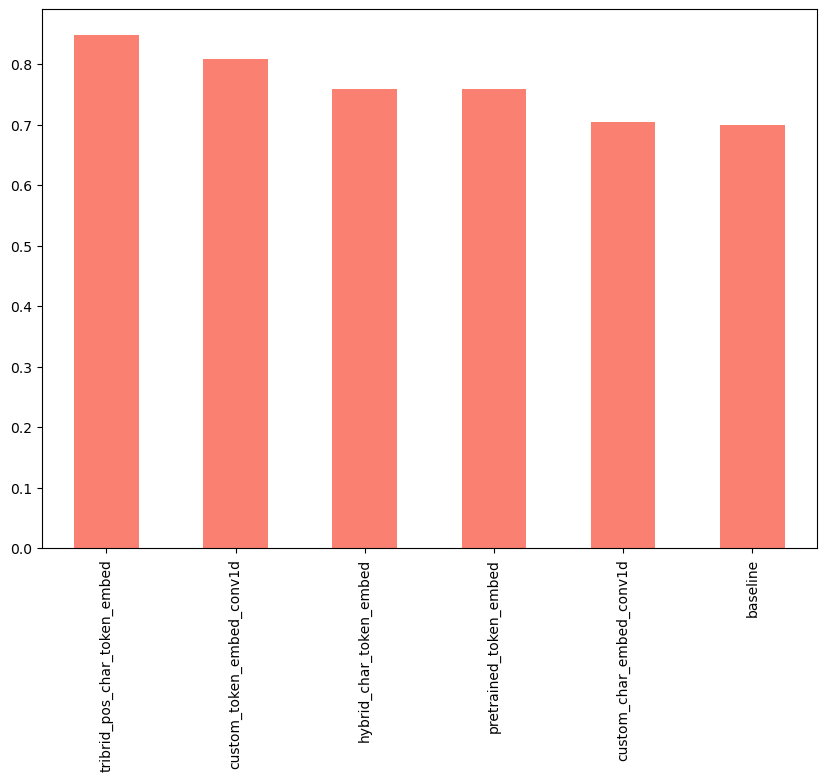

In [168]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7), color='salmon')

### Save and load model

In [171]:
model_path = "gs_model/tribrid_model/"
model_5.save(model_path)

INFO:tensorflow:Assets written to: skimlit_gs_model/skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_gs_model/skimlit_tribrid_model/assets


In [172]:
loaded_model = tf.keras.models.load_model(model_path)

In [175]:
loaded_model

In [176]:
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 58s 60ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1], dtype=int64)>

In [179]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 85.07546670197273,
 'precision': 0.8515471424909322,
 'recall': 0.8507546670197272,
 'f1': 0.8482333428221877}

In [180]:
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

array([ True,  True,  True,  True])

### Evaluate model on test dataset

In [182]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [183]:
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 56s 59ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0], dtype=int64)>

In [184]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 84.68558154969304,
 'precision': 0.8462088854712861,
 'recall': 0.8468558154969305,
 'f1': 0.8441910479112741}

### Find most wrong

In [185]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 '

In [187]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.382361,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.454037,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.863071,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.796401,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.781012,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.853610,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.616174,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.648407,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.571885,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.632509,True


In [188]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.971727,False
29294,RESULTS,"baseline measures included sociodemographics ,...",4,13,METHODS,0.953305,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.946259,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.939978,False
18720,RESULTS,non-diffuse-trickling '' ) .,8,15,BACKGROUND,0.935205,False
...,...,...,...,...,...,...,...
29170,CONCLUSIONS,the mean number of intravitreal injections was...,9,9,RESULTS,0.852572,False
9087,METHODS,ethical approval has been received from the na...,15,16,BACKGROUND,0.852193,False
27919,RESULTS,we sequentially allocated @ patients to a dosi...,2,13,METHODS,0.852077,False
15316,BACKGROUND,@ .,4,15,METHODS,0.851760,False


In [189]:
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
    _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
    print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
    print(f"Text:\n{text}\n")
    print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9717273712158203, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9533054828643799, Line number: 4, Total lines: 13

Text:
baseline measures included sociodemographics , standardized anthropometrics , asthma control test ( act ) , gerd symptom assessment scale , pittsburgh sleep quality index , and berlin questionnaire for sleep apnea .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9462592601776123, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.939978301525116, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: RESULTS, Pred: BACKGROUND, Prob: 0.9352051019668579, Line number: 8, Total lines: 15

Text:
non-diffuse-trickling '' ) .

-----

Target: CONCLUSION

### Make custom predictions

In [202]:
import json
with open("custom_abstract.json", "r") as f:
    custom_abstract = json.load(f)
custom_abstract

[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [203]:
abstracts = pd.DataFrame(custom_abstract)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [209]:
from spacy.lang.en import English
nlp = English()

sentencizer = nlp.add_pipe("sentencizer")

doc = nlp(custom_abstract[0]["abstract"]) 
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [210]:
total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [211]:
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [214]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [215]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [216]:
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 2s 2s/step


array([[0.38194528, 0.10133006, 0.03978412, 0.4249899 , 0.05195057],
       [0.10017027, 0.02943089, 0.7023585 , 0.12108468, 0.04695564],
       [0.08622063, 0.03541177, 0.6619875 , 0.11018719, 0.10619298],
       [0.09147071, 0.15326194, 0.45728704, 0.0736113 , 0.2243689 ],
       [0.04535759, 0.08655922, 0.20355132, 0.04130272, 0.62322915],
       [0.02939587, 0.05680735, 0.7146269 , 0.04053831, 0.15863141],
       [0.0242167 , 0.11479868, 0.07488413, 0.02540338, 0.7606971 ],
       [0.0121102 , 0.11634405, 0.14516911, 0.02376199, 0.7026146 ]],
      dtype=float32)

In [217]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 2, 4, 4], dtype=int64)>

In [218]:
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [219]:
for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
